# ***Retail Products Classification***
Kaggle-Id: *pondini*



### Overview  

1.   [Imports & Installation](#scrollTo=p3IRH__0aXie)  
  1.1   [Installation](#scrollTo=3RjRsjERbala)  
  1.2   [Imports](#scrollTo=yy3l0g6-caAN)  
  1.3   [QoL-Features](#scrollTo=Kb29OXErc5O-) 
2.   [Data Analytics](#scrollTo=ylsVIfhXHekI) 
3.   [Constants](#scrollTo=t-q7jRLyhM8u)
4.   [Preprocessing & Load data](#scrollTo=XzlWUul3jnnY)
5.   [Model approaches](#scrollTo=0bjMKjaDaIIH)
6.   [Final solution](#scrollTo=xGRHkr0MZT6g)  
  6.1   [Image classification](#scrollTo=nL4hJm_7wsYC)  
  6.2   [Text classification](#scrollTo=s3lRnZyXy_zT)  
  6.3   [Evaluation](#scrollTo=GcBG6Tt_Ctys)
7.   [Submission File](#scrollTo=RJCF_Hpsz-Y1)
8.   [Appendix](#scrollTo=aFTZL2DnRcSj)  
  8.1   [A) base solution](#scrollTo=eXt6c4UnjMY4)  
  8.2   [B) image classification neural networks](#scrollTo=a8LIhEyhoH3Z)  
  8.3   [C) image classification custom models](#scrollTo=-RNJ4qYYpbQE)  
  8.4   [D) Text classification (BERT)](#scrollTo=ro9T_CX0s8by)  
  8.5   [E) Data Augmentation](#scrollTo=w1k4pyODyN5T)
9.   [Sources](#scrollTo=eaFyxTMHkPWd)



# 1. Imports & Installation [↑](#scrollTo=QcPW_RtGRp8W)
The installation of the missing modules is performed below and all necessary imports are listed afterwards. 

In addition, a few qol-features are applied.

## Installation
Necessary installation of missing modules. 

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install keras_metrics
!pip install ktrain

Used modules in tests but not essential for the final solution. 

In [ ]:
!pip install bert-for-tf2

To interact properly with the kaggle api it's needed to reinstall the module. Otherwise not all data will be loaded correctly.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

## Imports
Every import of a module that was used once during the project is listed here.  
It could be that modules are imported that are no longer used. 

In [5]:
import os
from google.colab import drive
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling2D, Add, ReLU
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
from wordcloud import WordCloud
import gensim.downloader as api
import unicodedata
import re
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import csv
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import bert
import math
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
import ktrain
from ktrain import text
from collections import defaultdict
from collections import Counter

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## "Quality of life" Features
Mount google drive to colab to access google drive from the notebook

In [8]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In order to be able to use the Kaggle command it is necessary to create a '/.kaggle' directory.  
The 'kaggle.json'-File must be placed there. 

In [7]:
!mkdir ~/.kaggle

Copy kaggle.json from google drive to the created directory. 

In [ ]:
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c retail-products-classification

!unzip retail-products-classification.zip

Check if all files were downloaded, else raise an exception, to stop further execution.


In [10]:
class FileNumberError(Exception):
  pass

In [11]:
train_files = []
for file in os.listdir('train/train/'):
    if file.endswith(".jpg"):
        train_files.append(file.replace(".jpg", ""))
print(len(train_files))

test_files = []
for file in os.listdir('test/test/'):
    if file.endswith(".jpg"):
        test_files.append(file.replace(".jpg", ""))
print(len(test_files))

if((len(train_files) != 42000)):
  raise FileNumberError('Wrong number of training files')

if((len(test_files) != 6367)):
  raise FileNumberError('Wrong number of testing files')

42000
6367


# 2. Data analytics [↑](#scrollTo=QcPW_RtGRp8W)

In [12]:
data = pd.read_csv('train.csv')

In [13]:
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


Number of characters

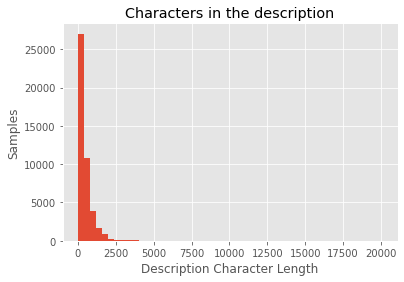

In [14]:
plt.hist(data['description'].str.len(), bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Character Length')
plt.title('Characters in the description')
plt.show()

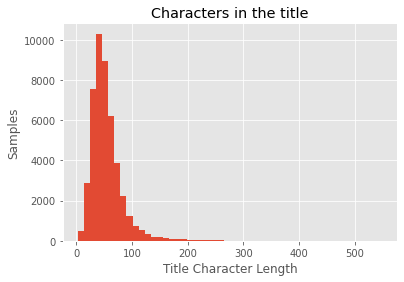

In [15]:
plt.hist(data['title'].str.len(), bins=50)
plt.ylabel('Samples')
plt.xlabel('Title Character Length')
plt.title('Characters in the title')
plt.show()

Number of words 

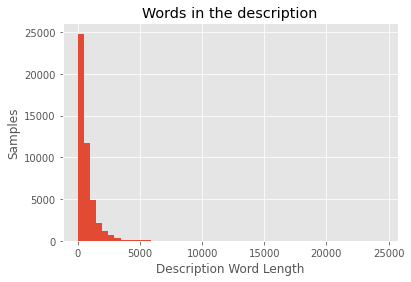

In [16]:
plt.hist(data['description'].str.split().map(lambda x: len(str(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Word Length');
plt.title('Words in the description')
plt.show()

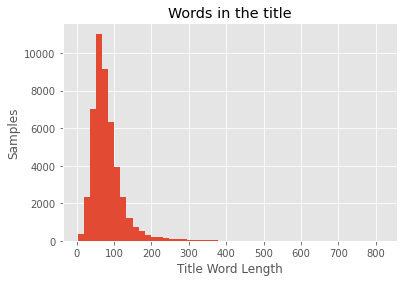

In [17]:
plt.hist(data['title'].str.split().map(lambda x: len(str(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Title Word Length');
plt.title('Words in the title')
plt.show()

Average word length

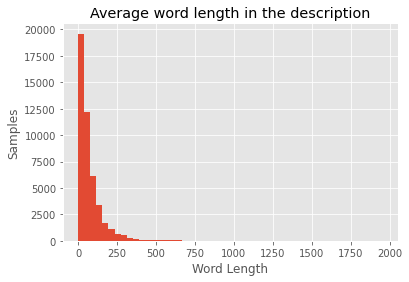

In [18]:
plt.hist(data['description'].str.split().apply(lambda x: x if isinstance(x, list) else []).map(lambda x: np.mean(len(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Word Length');
plt.title('Average word length in the description')
plt.show()

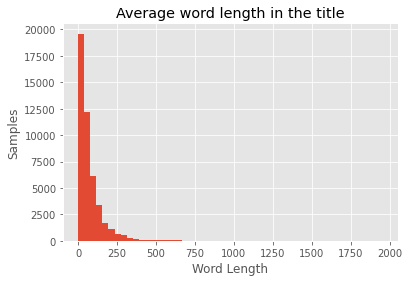

In [19]:
plt.hist(data['description'].str.split().apply(lambda x: x if isinstance(x, list) else []).map(lambda x: np.mean(len(x))), bins=50)
plt.ylabel('Samples')
plt.xlabel('Word Length');
plt.title('Average word length in the title')
plt.show()

Plot most used stopwords

In [20]:
analytics_corpus=[]
description= data['description'].str.split().apply(lambda x: x if isinstance(x, list) else [])
description=description.values.tolist()
analytics_corpus=[word for i in description for word in i]

dic=defaultdict(int)
for word in analytics_corpus:
    if word in stop_english:
        dic[word]+=1

keys = [x[0] for x in sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]]
values = [x[1] for x in sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]]

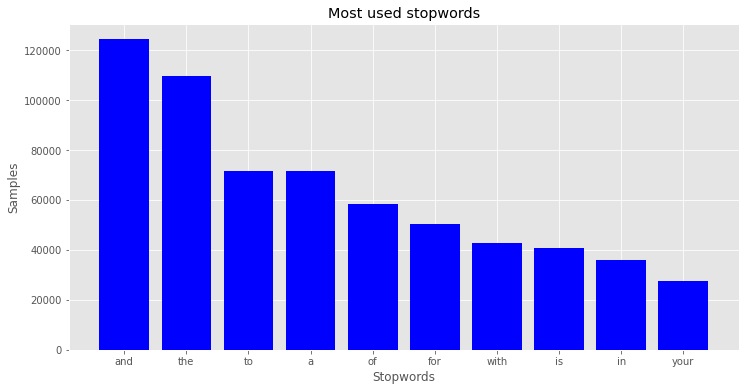

In [21]:
plt.figure(figsize=(12,6))
plt.bar(keys, values, align='center', color='b')
plt.ylabel('Samples')
plt.xlabel('Stopwords');
plt.title('Most used stopwords')
plt.show()

Plot most used non stopwords

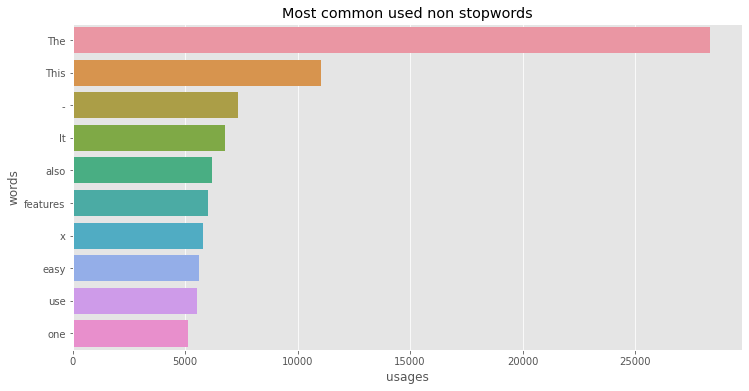

In [23]:
plt.figure(figsize=(12,6))
counter=Counter(analytics_corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:40]:
    if (word not in stop_english):
        x.append(word)
        y.append(count)
        
ax = sns.barplot(x=y,y=x)
ax.set_title('Most common used non stopwords')
ax.set_ylabel('words')
ax.set_xlabel('usages')
plt.show()

### WordCloud
Represents the text data. The size and color of each word that appears indicate it's frequency or importance. 

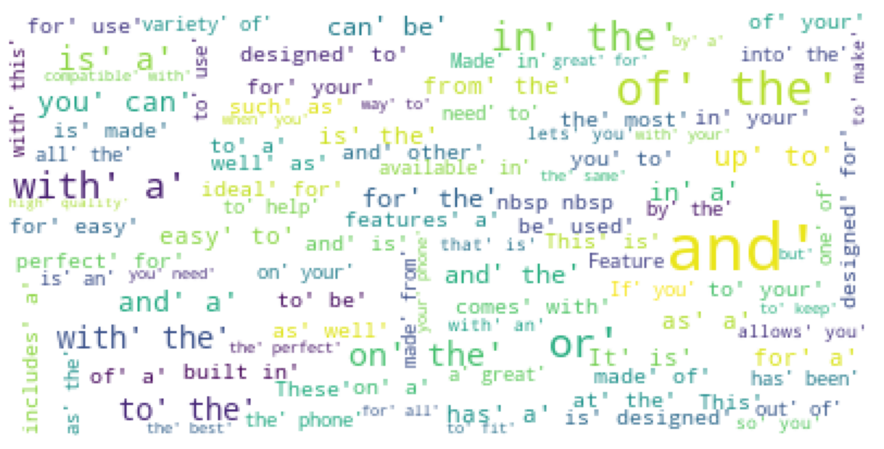

In [24]:
plt.figure(figsize=(16,8))
word_cloud = WordCloud(background_color='white',
                        max_font_size = 30,
                        max_words=100
                      ).generate(str(analytics_corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Categories
Plot the different categories

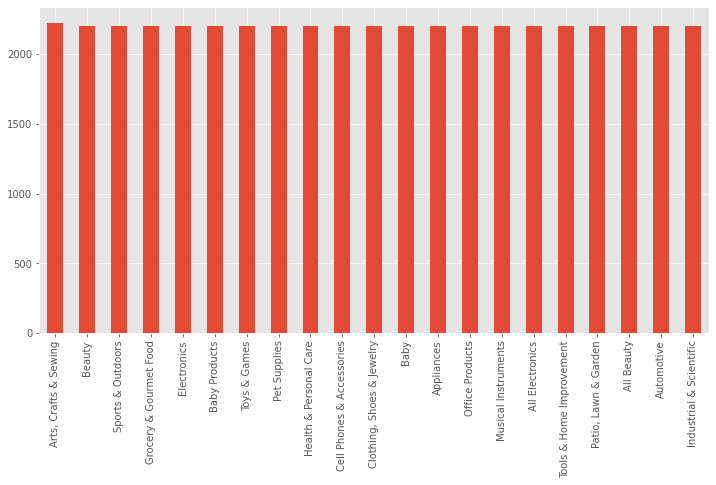

In [25]:
data['categories'].value_counts().plot(kind='bar', figsize=(12, 6));

# 3. Constants [↑](#scrollTo=QcPW_RtGRp8W)
Create some important constants

In [26]:
CATEGORIES = ['Electronics', 'Sports & Outdoors', 
              'Cell Phones & Accessories', 'Automotive', 
              'Toys & Games', 'Tools & Home Improvement', 
              'Health & Personal Care', 'Beauty', 
              'Grocery & Gourmet Food', 'Office Products',
              'Arts, Crafts & Sewing', 'Pet Supplies', 
              'Patio, Lawn & Garden', 'Clothing, Shoes & Jewelry', 
              'Baby', 'Musical Instruments', 
              'Industrial & Scientific', 'Baby Products', 
              'Appliances', 'All Beauty', 'All Electronics']

In [27]:
train_images_path = 'train/train'
IMG_SIZE = (100,100)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 15
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01
MAX_LEN = 40

# 4. Preprocessing & Load data [↑](#scrollTo=QcPW_RtGRp8W)

In [30]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [31]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [32]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

More unused preprocessing steps are in the appendix. ([Preprocessing BERT](#scrollTo=jOZoJkyat8r7))

### Load Data

Tried to up and downscale the image size multiple times.  
Larger image sizes resulted in higher accuracy values. 100x100 pixels were chosen because there was too little RAM available for large images.  
Smaller image sizes resulted in lower accuracy values. 

In [28]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(100,100))
    img_array = img_to_array(image)
    return img_array

In [33]:
columns = ['text', 'label']
clean_data = pd.DataFrame(columns=columns)

corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                final_text = str(title) + ' ' + str(description)
                corpus.append(final_text)
                clean_data = clean_data.append({'text': final_text, 'label': family}, ignore_index=True)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

# 5. Model approaches [↑](#scrollTo=QcPW_RtGRp8W)

In the first step, the base solution, which can be found on Kaggle, was executed several times. Then, different models for image classification were investigated. In this Notebook are some code artifacts used from the base solution on Kaggle. [¹](https://www.kaggle.com/imlahsoffenburg/retail-product-classification)    
All used models can be found in the appendix ([A) image and text classification neural networks](#scrollTo=eXt6c4UnjMY4))


In the next step, image and text classification were separated from each other. 
Afterwards, image and text classification models were tested individually.  
All used models can be found in the appendix ([B) image classification neural network](#scrollTo=a8LIhEyhoH3Z), [C) image classification custom models](#scrollTo=-RNJ4qYYpbQE), [D) Text classification (BERT)](#scrollTo=ro9T_CX0s8by))

## Conclusion
AlexNet, VGG-16, ResNet-18 are too undercomplex. The influence variables do not sufficiently describe the target variables. So the models are underfitting. As a result, the model does not predict the target variables well.  
More complex neural networks such as mobilenet also do not predict the target variable well. Large complex neural networks such as mobilenetv3large are overfitting. So the best network would have to be somewhere in between.  
In general, the image classifiction does not seem to perform well as text classification. Therefore, the focus is placed on a good text classification model: BERT.  



# 6. Final model solution [↑](#scrollTo=QcPW_RtGRp8W)

### 6.1 Image Classification

In [39]:
input_tensor = Input(shape=INPUT_SHAPE)
base_model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights='imagenet')

output = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(base_model.output)
output = tf.keras.layers.Dropout(.4)(output)
output = tf.keras.layers.Flatten()(output)

predictions = tf.keras.layers.Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax')(output)

final_model = tf.keras.models.Model(base_model.input, predictions, name='Image-Model')

17227776/17225924 [==============================] - 0s 0us/step


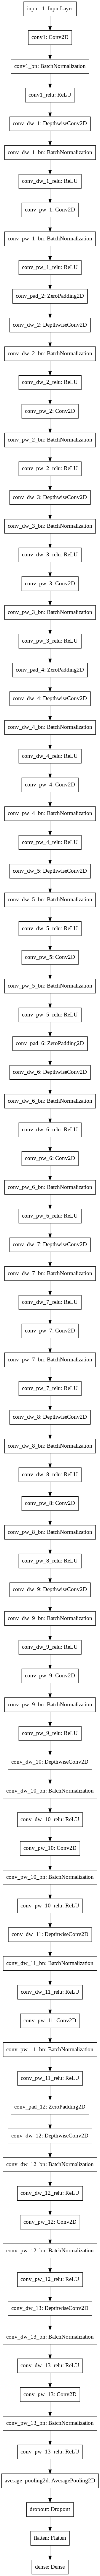

In [46]:
plot_model(final_model)

In [40]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
corpus_test = corpus[p:]

In [41]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)

Shape of train (33600, 100, 100, 3)
Shape of Validation  (8400, 100, 100, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)


**Data Augmentation**  
Different values of these transformations possibilities were tested. More ImageDataGenerator can be found in the appendix. [Data Augmentation](#scrollTo=w1k4pyODyN5T)  
These are the final settings for data augmentation. 

In [42]:
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         zoom_range = 0.2,
                         shear_range = 0.2,
                         rotation_range = 40,
                         fill_mode='nearest')

def gen_flow_for_two_inputs(X1, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            yield X1i[0], X1i[1]
            
# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, label_train)

**Compile Model**  

In [43]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
callbacks = [early_stop, reduce_lr]

final_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

**Train the Model**

In [45]:
tf.debugging.set_log_device_placement(True)

try:
  with tf.device('/GPU:0'):
    history = final_model.fit(gen_flow, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=(len(image_train) // BATCH_SIZE)*3, validation_data=(image_test,label_test))
except RuntimeError as e:
  print(e)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


3150/3150 [==============================] - 294s 87ms/step - loss: 2.6450 - accuracy: 0.2281 - precision: 0.4348 - recall: 0.0433 - val_loss: 2.4669 - val_accuracy: 0.2675 - val_precision: 0.5600 - val_recall: 0.0817
Epoch 2/15
3150/3150 [==============================] - 272s 86ms/step - loss: 2.3841 - accuracy: 0.2948 - precision: 0.5927 - recall: 0.1088 - val_loss: 2.5676 - val_accuracy: 0.2787 - val_precision: 0.6291 - val_recall: 0.1255
Epoch 3/15
3150/3150 [==============================] - 269s 85ms/step - loss: 2.2503 - accuracy: 0.3378 - precision: 0.6543 - recall: 0.1433 - val_loss: 2.3692 - val_accuracy: 0.3220 - val_precision: 0.6638 - val_recall: 0.1631
Epoch 4/15
3150/3150 [==============================] - 266s 85ms/step - loss: 2.1265 - accuracy: 0.3745 - precision: 0.6705 - recall: 0.1819 - val_loss: 2.5315 - val_accuracy: 0.2967 - val_precision: 0.6749 - val_recall: 0.1971
Epoch 5/15
3150/3150 [==============================] - 265s 84ms/step - loss: 2.0223 - accurac

### 6.2 Text Classification

In [47]:
p = int((len(clean_data)*80)/100)
train_data = clean_data[:p]
val_data = clean_data[p:]

Using Bert from ktrain module

In [49]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train_data, 
                                                                  text_column='text', 
                                                                  label_columns=['label'],
                                                                  val_df=val_data,
                                                                  preprocess_mode='bert',
                                                                  maxlen=MAX_LEN)

['All Beauty', 'All Electronics', 'Appliances', 'Arts, Crafts & Sewing', 'Automotive', 'Baby', 'Baby Products', 'Beauty', 'Cell Phones & Accessories', 'Clothing, Shoes & Jewelry', 'Electronics', 'Grocery & Gourmet Food', 'Health & Personal Care', 'Industrial & Scientific', 'Musical Instruments', 'Office Products', 'Patio, Lawn & Garden', 'Pet Supplies', 'Sports & Outdoors', 'Tools & Home Improvement', 'Toys & Games']
   All Beauty  All Electronics  ...  Tools & Home Improvement  Toys & Games
0         0.0              0.0  ...                       0.0           0.0
1         0.0              0.0  ...                       1.0           0.0
2         0.0              0.0  ...                       0.0           0.0
3         0.0              0.0  ...                       0.0           0.0
4         0.0              0.0  ...                       0.0           0.0

[5 rows x 21 columns]
['All Beauty', 'All Electronics', 'Appliances', 'Arts, Crafts & Sewing', 'Automotive', 'Baby', 'Baby

Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 40
done.


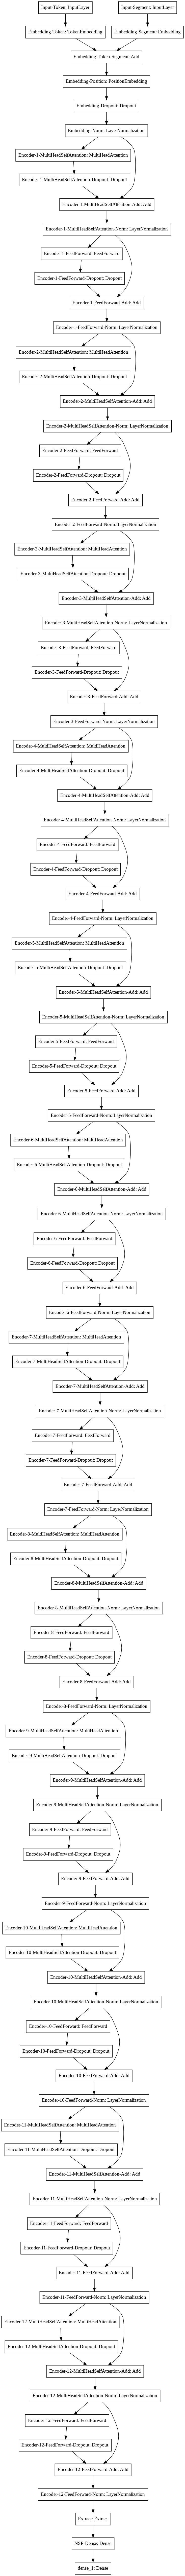

In [50]:
text_classifier = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
plot_model(text_classifier)

In [51]:
learner = ktrain.get_learner(text_classifier,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=BATCH_SIZE)

In [52]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
      bert_history = learner.fit_onecycle(1e-4, 6)
except RuntimeError as e:
  print(e)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/6
1050/1050 [==============================] - 316s 285ms/step - loss: 1.2397 - accuracy: 0.6214 - val_loss: 0.7450 - val_accuracy: 0.7623
Epoch 2/6
1050/1050 [==============================] - 293s 279ms/step - loss: 0.6219 - accuracy: 0.8076 - val_loss: 0.6675 - val_accuracy: 0.8069
Epoch 3/6
1050/1050 [==============================] - 292s 278ms/step - loss: 0.4552 - accuracy: 0.8574 - val_loss: 0.7400 - val_accuracy: 0.7906
Epoch 4/6
1050/1050 [==============================] - 292s 278ms/step - loss: 0.2987 - accuracy: 0.9065 - val_loss: 0.6966 - val_accuracy: 0.8167
Epoch 5/6
1050/1050 [==============================] - 292s 278ms/step - loss: 0.1090 - accuracy: 0.9653 - val_loss: 0.7272 - val_accuracy: 0.8362
Epoch 6/6
1050/1050 [==============================] - 292s 278ms/step - loss: 0.0252 - accuracy: 0.9927 - val_loss: 0.7851 - val_accuracy: 0.8431


### 6.3 Evaluation

Get Predictor for Bert Model from ktrain

In [53]:
predictor = ktrain.get_predictor(learner.model, preproc)
# predictorLoad = ktrain.load_predictor('./')

Predictions for image classification model

In [54]:
predictions = final_model.predict(image_test,batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 32s


In [55]:
cm=confusion_matrix(y_test,classes)

Text(0.5, 114.0, 'Predicted label')

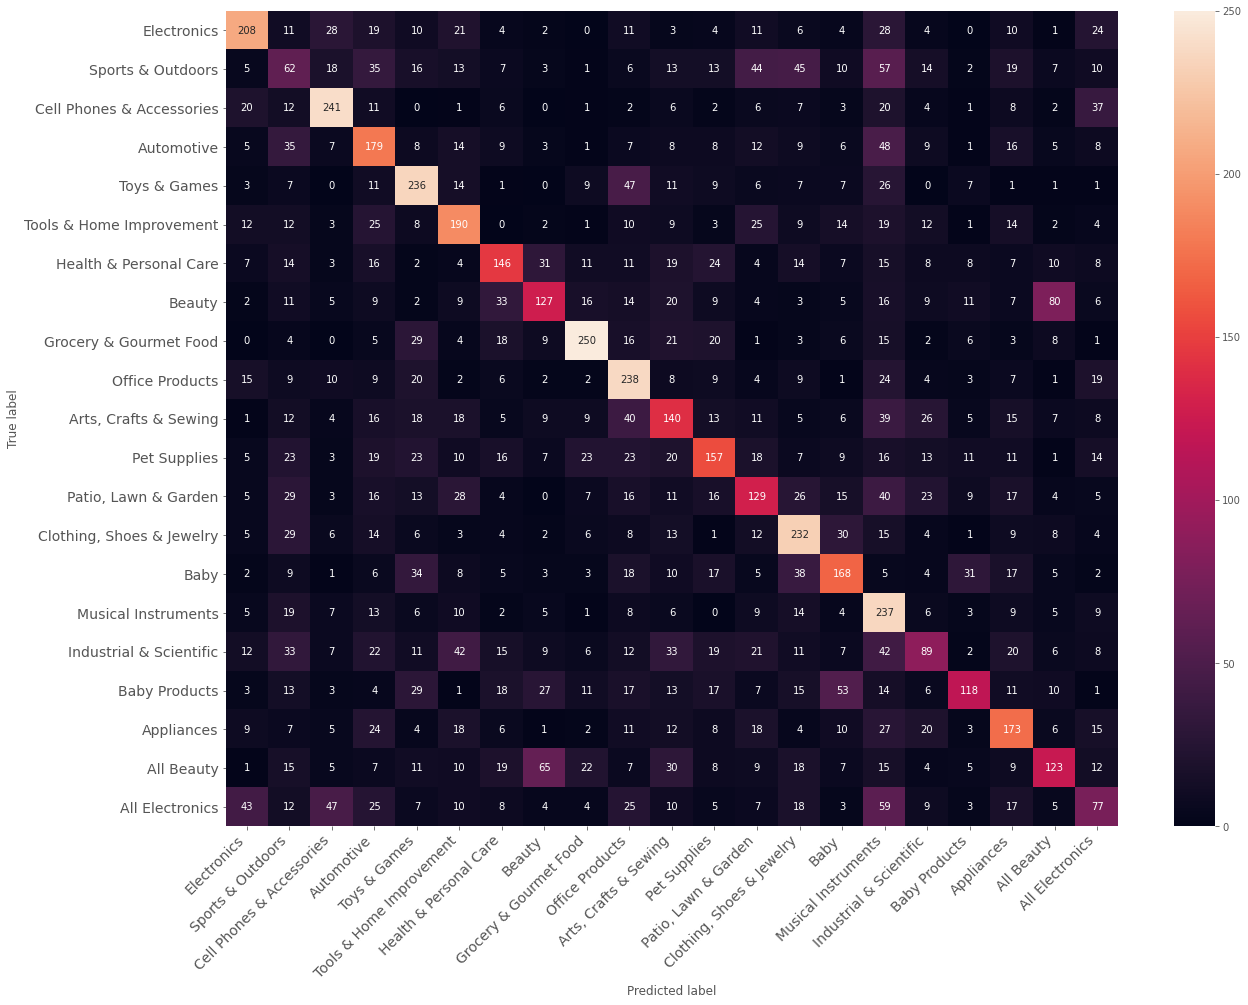

In [56]:
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

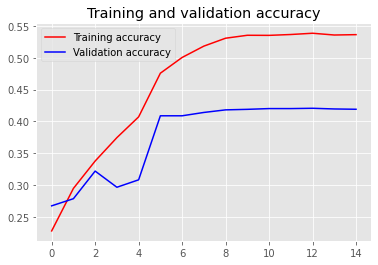

<Figure size 432x288 with 0 Axes>

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

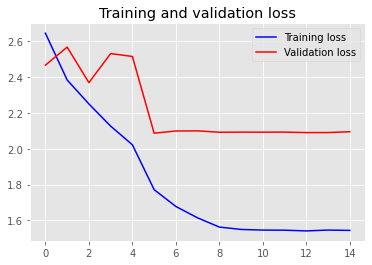

In [58]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
predictions = predictor.predict(corpus_test)
classes = list(map(lambda x: CATEGORIES.index(x), predictions))
y_test = np.argmax(label_test, axis = 1)

In [63]:
cm=confusion_matrix(y_test,classes)

Text(0.5, 114.0, 'Predicted label')

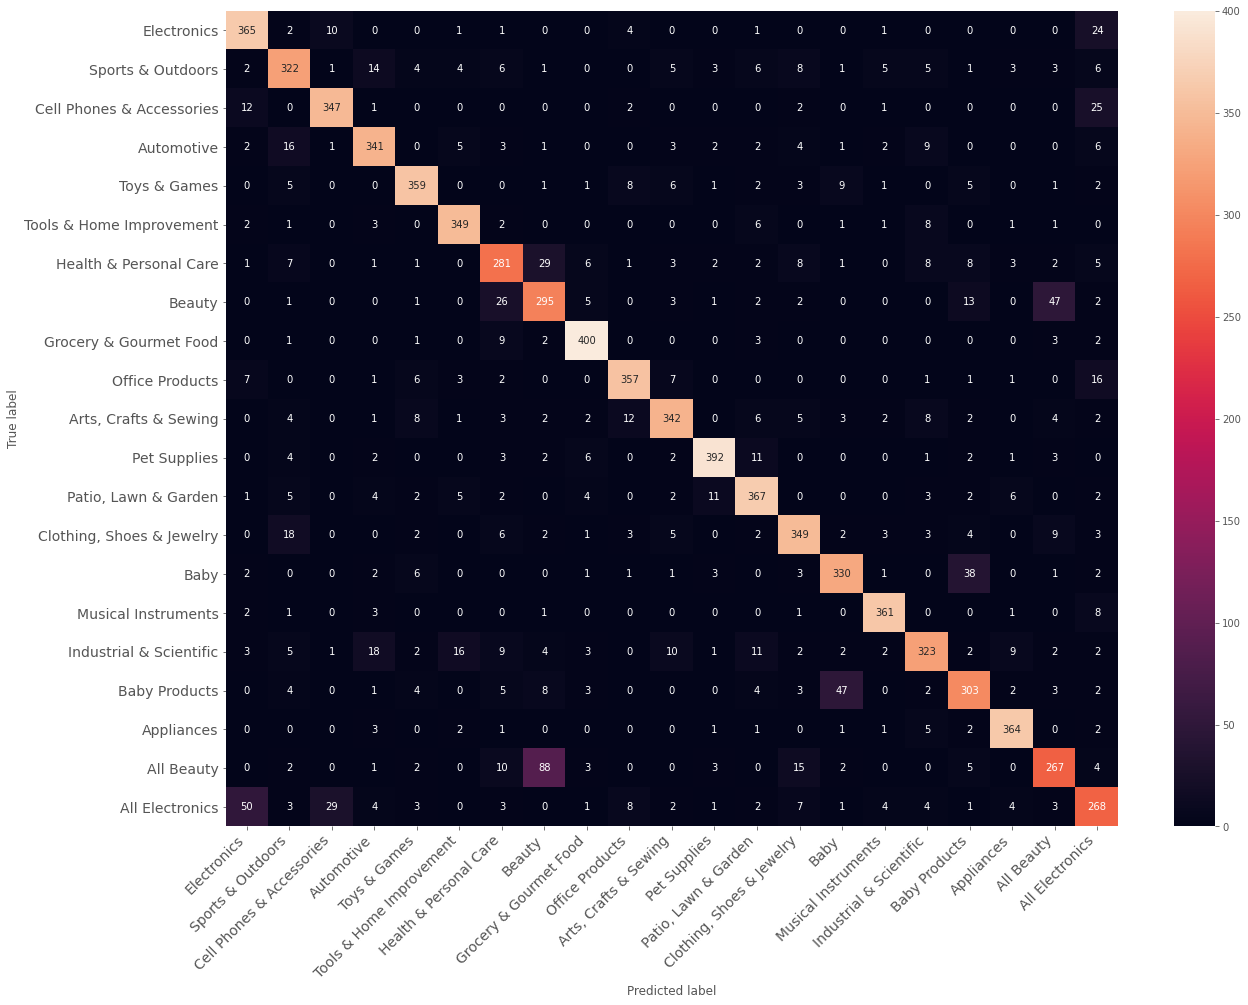

In [64]:
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

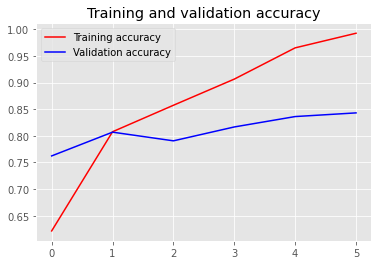

<Figure size 432x288 with 0 Axes>

In [65]:
acc = bert_history.history['accuracy']
val_acc = bert_history.history['val_accuracy']
loss = bert_history.history['loss']
val_loss = bert_history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

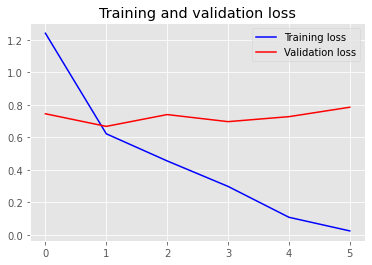

In [66]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

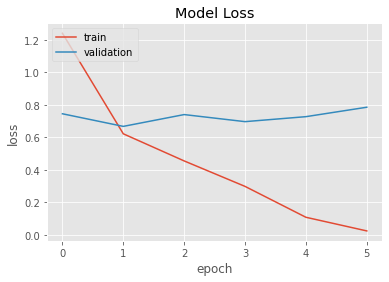

In [67]:
learner.plot('loss')
plt.show()

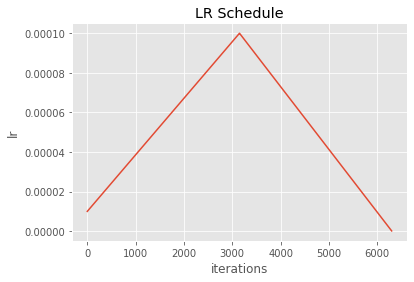

In [68]:
learner.plot('lr')
plt.show()

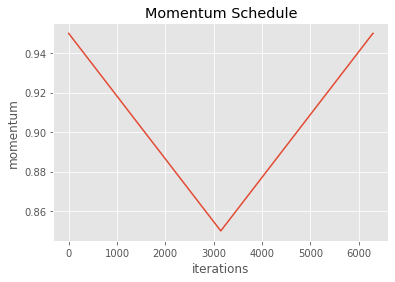

In [84]:
learner.plot('momentum')
plt.show()

In [ ]:
# didn't work in last workflow, therefore just an old output
learner.evaluate((x_test, y_test), class_names=CATEGORIES)

                               precision    recall  f1-score   support

                   All Beauty       0.74      0.72      0.73       376
              All Electronics       0.66      0.63      0.64       392
                   Appliances       0.95      0.94      0.94       407
        Arts, Crafts & Sewing       0.84      0.85      0.84       401
                   Automotive       0.84      0.88      0.86       377
                         Baby       0.80      0.84      0.82       402
                Baby Products       0.81      0.72      0.77       419
                       Beauty       0.73      0.74      0.74       398  
    Cell Phones & Accessories       0.86      0.90      0.88       385    
    Clothing, Shoes & Jewelry       0.83      0.83      0.83       378
                  Electronics       0.85      0.89      0.87       411  
       Grocery & Gourmet Food       0.94      0.95      0.95       417  
       Health & Personal Care       0.78      0.75      0.77       416  
      Industrial & Scientific       0.83      0.81      0.82       410
          Musical Instruments       0.94      0.94      0.94       371
              Office Products       0.89      0.89      0.89       407
         Patio, Lawn & Garden       0.90      0.88      0.89       408
                 Pet Supplies       0.91      0.95      0.93       421
            Sports & Outdoors       0.82      0.80      0.81       390
     Tools & Home Improvement       0.90      0.92      0.91       403
                 Toys & Games       0.89      0.92      0.91       411

                     accuracy                           0.85      8400
                    macro avg       0.84      0.85      0.84      8400
                 weighted avg       0.85      0.85      0.85      8400

# 7. Submission File [↑](#scrollTo=QcPW_RtGRp8W)

In [89]:
test_data = pd.read_csv('test.csv')

In [90]:
test_images_path = 'test/test/'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(100,100))
    img_array = img_to_array(image)
    return img_array

In [91]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir('test/test/')
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = test_data[test_data['ImgId']==img_id].index.values[0]
            row = test_data.iloc[index , :]
            description = row[2]
            title = row[1]
            text = str(title) + ' ' + str(description)
            test_images.append(img_array.astype('float32'))
            test_corpus.append((str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

In [92]:
pred_bert = predictor.predict(test_corpus)

pred_proba = predictor.predict_proba(test_corpus)
pred_cnn = final_model.predict(test_images,batch_size=1,verbose = 2)

6367/6367 - 25s


predict_proba returns the values in the wrong order. This will correct it.

In [158]:
corrected = np.array([[i[10], i[18], i[8], i[4], i[20], i[19], i[12], 
           i[7], i[11], i[15], i[3], i[17], i[16], i[9], 
           i[5], i[14], i[13], i[6], i[2], i[0], i[1]] for i in pred_proba])

In [159]:
predictions = corrected + pred_cnn
classes = np.argmax(predictions, axis = 1)

## Create Submission File

In [160]:
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(classes):
        metadata_writer.writerow([test_image_ids[i], classes[i]])

Save submission file on google drive

In [161]:
!cp submission.csv /content/gdrive/MyDrive/submissions/submission.csv

# 8. Appendix [↑](#scrollTo=QcPW_RtGRp8W)

## A) image and text classification neural networks

In combination with the text classification model


MobileNet: ~75% Test accuracy on Kaggle

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)

output = tf.keras.layers.Reshape((4096,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

MobileNetV2: ~72% Test accuracy on evaluation data (not on Kaggle data)

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNetV2(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)

output = tf.keras.layers.Reshape((3*3*1280,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

MobileNetV3Large: <70% Test accuracy on evaluation data (not on Kaggle data)

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNetV3Large(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)

output = tf.keras.layers.Reshape((3*3*1280,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

MobileNetV3Small: ~71% Test accuracy on evaluation data (not on Kaggle data)

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNetV3Small(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)

output = tf.keras.layers.Reshape((3*3*1280,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

EfficientNetB0: ~72% Test accuracy on evaluation data (not on Kaggle data)

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = EfficientNetB0(input_tensor=input_tensor, classes=NUM_CLASSES,
                    include_top=False, weights=None)

output = tf.keras.layers.Reshape((3*3*1280,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

Text classification combination

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense,
    out
])

Concatenate both models

In [ ]:
merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(100, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

## B) image classification neural networks

MobileNet: accuracy: 0.6126 - val_accuracy: 0.3932

InceptionV3: accuracy: 0.1464 - val_accuracy: 0.1413

MobileNetV2: accuracy: 0.7030 - val_accuracy: 0.3806

MobileNetV3Small: accuracy: 0.5438 - val_accuracy: 0.3681

MobileNetV3Large: accuracy: 0.7743 - val_accuracy: 0.4023

Xception: accuracy: 0.7860 - val_accuracy: 0.4121

VGG16: accuracy: 0.0487 - val_accuracy: 0.0435

ResNet50: accuracy: 0.4942 - val_accuracy: 0.3471

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
base_model = MobileNet(input_tensor=input_tensor, include_top=False, weights='imagenet')
# base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights='imagenet')
# ...

output = base_model.output
output = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(output)
output = tf.keras.layers.Dropout(.4)(output)
output = tf.keras.layers.Flatten()(output)

predictions = tf.keras.layers.Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax')(output)

model_cnn = tf.keras.models.Model(base_model.input, predictions, name='Image-Model')

# C) image classification custom models

### VGG1

In [ ]:
def build_custom_model():
  input_tensor = Input(shape=INPUT_SHAPE)
  model = Sequential([
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),

    Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax')
  ])


  return model

custom_model = build_custom_model()

custom_model.summary()

## ResNet-18

In [ ]:
def build_resnet18():
  input = Input(shape=INPUT_SHAPE)
  init_conv = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(input)
  init_bn = BatchNormalization()(init_conv)
  init_relu = ReLU()(init_bn)

  max_pool = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(init_relu)

  # first block
  inputs_1 = max_pool

  conv_1_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(max_pool)
  bn_1_1 = BatchNormalization()(conv_1_1)
  relu_1 = ReLU()(bn_1_1)
  conv_1_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(relu_1)
  bn_1_2 = BatchNormalization()(conv_1_2)
  added_1 = Add()([bn_1_2, inputs_1])
  relu_1_2 = ReLU()(added_1)

  # second block
  inputs_2 = relu_1_2

  conv_2_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(relu_1_2)
  bn_2_1 = BatchNormalization()(conv_2_1)
  relu_2 = ReLU()(bn_2_1)
  conv_2_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(relu_2)
  bn_2_2 = BatchNormalization()(conv_2_2)
  added_2 = Add()([bn_2_2, inputs_2])
  relu_2_2 = ReLU()(added_2)

  # third block
  inputs_3 = relu_2_2

  conv_3_1 = Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same')(relu_2_2)
  bn_3_1 = BatchNormalization()(conv_3_1)
  relu_3 = ReLU()(bn_3_1)
  conv_3_2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(relu_3)
  bn_3_2 = BatchNormalization()(conv_3_2)

  # down sampling
  inputs_3 = Conv2D(128, kernel_size=(1,1), strides=(2,2), padding='same')(inputs_3)
  inputs_3 = BatchNormalization()(inputs_3)

  added_3 = Add()([bn_3_2, inputs_3])
  relu_3_2 = ReLU()(added_3)

  # forth block
  inputs_4 = relu_3_2

  conv_4_1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(relu_3_2)
  bn_4_1 = BatchNormalization()(conv_4_1)
  relu_4 = ReLU()(bn_4_1)
  conv_4_2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(relu_4)
  bn_4_2 = BatchNormalization()(conv_4_2)
  added_4 = Add()([bn_4_2, inputs_4])
  relu_4_2 = ReLU()(added_4)

  # fifth
  inputs_5 = relu_4_2

  conv_5_1 = Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same')(relu_4_2)
  bn_5_1 = BatchNormalization()(conv_5_1)
  relu_5 = ReLU()(bn_5_1)
  conv_5_2 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(relu_5)
  bn_5_2 = BatchNormalization()(conv_5_2)

  # down sampling
  inputs_5 = Conv2D(256, kernel_size=(1,1), strides=(2,2), padding='same')(inputs_5)
  inputs_5 = BatchNormalization()(inputs_5)

  added_5 = Add()([bn_5_2, inputs_5])
  relu_5_2 = ReLU()(added_5)

  # sixth
  inputs_6 = relu_5_2

  conv_6_1 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(relu_5_2)
  bn_6_1 = BatchNormalization()(conv_6_1)
  relu_6 = ReLU()(bn_6_1)
  conv_6_2 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(relu_6)
  bn_6_2 = BatchNormalization()(conv_6_2)
  added_6 = Add()([inputs_6, bn_6_2])
  relu_6_2 = ReLU()(added_6)

  # seventh
  inputs_7 = relu_6_2

  conv_7_1 = Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same')(relu_6_2)
  bn_7_1 = BatchNormalization()(conv_7_1)
  relu_7 = ReLU()(bn_7_1)
  conv_7_2 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(relu_7)
  bn_7_2 = BatchNormalization()(conv_7_2)

  # down sampling
  inputs_7 = Conv2D(512, kernel_size=(1,1), strides=(2,2), padding='same')(inputs_7)
  inputs_7 = BatchNormalization()(inputs_7)

  added_7 = Add()([bn_7_2, inputs_7])
  relu_7_2 = ReLU()(added_7)

  # eigth
  inputs_8 = relu_7_2

  conv_8_1 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(relu_7_2)
  bn_8_1 = BatchNormalization()(conv_8_1)
  relu_8 = ReLU()(bn_8_1)
  conv_8_2 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(relu_8)
  bn_8_2 = BatchNormalization()(conv_8_2)
  added_8 = Add()([inputs_8, bn_8_2])
  relu_8_2 = ReLU()(added_8)

  avg_pool = GlobalAveragePooling2D()(relu_8_2)
  flatten = Flatten()(avg_pool)

  out = Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax')(flatten)

  model = tf.keras.Model(input, outputs=out)
  
  return model

## Custom
Accuracy: 0.1567 - val-accuracy: 0.1435

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)

custom_model = Sequential()

custom_model.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=INPUT_SHAPE))

custom_model.add(tf.keras.layers.Conv2D(75, kernel_size=(3,3), strides=(1,1), activation='relu'))
custom_model.add(tf.keras.layers.MaxPool2D(pool_size=(16,16)))
custom_model.add(tf.keras.layers.Dropout(.25))

custom_model.add(tf.keras.layers.Conv2D(125, kernel_size=(3,3), strides=(1,1), activation='relu'))
custom_model.add(tf.keras.layers.MaxPool2D(pool_size=(8,8)))
custom_model.add(tf.keras.layers.Dropout(.25))

custom_model.add(tf.keras.layers.Conv2D(150, kernel_size=(3,3), strides=(1,1), activation='relu'))
custom_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,4)))
custom_model.add(tf.keras.layers.Dropout(.25))

custom_model.add(tf.keras.layers.Flatten())

# custom_model.add(tf.keras.layers.AveragePooling2D(pool_size=(4,4)))
custom_model.add(tf.keras.layers.Dense(1000, activation='relu'))
custom_model.add(tf.keras.layers.Dropout(.4))
custom_model.add(tf.keras.layers.Dense(750, activation='relu'))
custom_model.add(tf.keras.layers.Dropout(.4))
custom_model.add(tf.keras.layers.Dense(500, activation='relu'))
custom_model.add(tf.keras.layers.Dropout(.4))
custom_model.add(tf.keras.layers.Dense(200, activation='relu'))
custom_model.add(tf.keras.layers.Dropout(.3))
custom_model.add(tf.keras.layers.Flatten())

custom_model.add(tf.keras.layers.Dense(100, activation='relu'))

custom_model.add(tf.keras.layers.Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax'))


Custom Model:  
accuracy: 0.3538 - val_accuracy: 0.2521

In [ ]:
def build_model():
  input_tensor = Input(shape=INPUT_SHAPE)
  model = Sequential([              
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', input_shape=INPUT_SHAPE),
    BatchNormalization(),

    # first block
    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # second block
    DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(128, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # third
    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(128, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # fourth
    DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # sixth
    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # seventh
    DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    # eigth - twelth
    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='same'),
    BatchNormalization(),
    ReLU(),

    MaxPooling2D((1,1)),
    Dropout(0.2),

    AveragePooling2D((5,5), strides=(1,1)),
    Flatten(),
    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.005), activity_regularizer=tf.keras.regularizers.l1(0.005), activation='softmax')
  ])
  
  return model

# D) Text classification (BERT)

1. BERT [²](https://github.com/artelab/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs)  
The first Bert approach was used from the linked GitHub Page above. [³](https://paperswithcode.com/paper/image-and-text-fusion-for-upmc-food-101-using)

2. BERT

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [ ]:
columns = ['text', 'label']
clean_data = pd.DataFrame(columns=columns)

files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                class_num = CATEGORIES.index(family)
                final_text = str(title) + ' ' + str(description)
                clean_data = clean_data.append({'text': preprocess_sentence(final_text), 'label': class_num}, ignore_index=True)
        except IndexError as error:
            print(error)

In [ ]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = image_labels[:p]
label_test = image_labels[p:]

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=21)

In [ ]:
sentences = clean_data["text"]
labels = clean_data["label"]

In [ ]:
input_ids = []
attention_masks = []

for sent in sentences:
  bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
  input_ids.append(bert_inp['input_ids'])
  attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
train_inp = np.asarray(train_inp).astype(np.int32)
train_mask = np.asarray(train_mask).astype(np.int32)
train_label = np.asarray(train_label).astype(np.int32)

val_inp = np.asarray(val_inp).astype(np.int32)
val_mask = np.asarray(val_mask).astype(np.int32)
val_label = np.asarray(val_label).astype(np.int32)

In [ ]:
tf.debugging.set_log_device_placement(True)
tf.config.run_functions_eagerly(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history=bert_model.fit([train_inp,train_mask],train_label,batch_size=BATCH_SIZE,epochs=8,validation_data=([val_inp,val_mask],val_label))
except RuntimeError as e:
  print(e)

3. BERT
[⁴](https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/)

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=50):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
    text = tokenizer.tokenize(text)

    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(input_sequence)

    tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=50):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)    
    return model

In [ ]:
max_len = 50
train_input = bert_encode(train_data.text.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.text.values, tokenizer, max_len=max_len)

In [ ]:
bert_model = build_model(bert_layer, max_len=max_len)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
callbacks = [early_stop, reduce_lr]

bert_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = bert_model.fit(train_input, train_labels, batch_size=2,
                    epochs=3, verbose=1, callbacks=callbacks, steps_per_epoch=len(train_input[0]) // 2, validation_data=(test_input,test_labels))
except RuntimeError as e:
  print(e)

# E) Data Augmentation

In [ ]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         shear_range = 0.1,
                         rotation_range = 20,
                         fill_mode='nearest')

In [ ]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         zoom_range = 0.2,
                         rotation_range = 20,
                         fill_mode='nearest')

In [ ]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         rotation_range = 50,
                         fill_mode='nearest')

In [ ]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.3,
                         height_shift_range = 0.3,
                         zoom_range = 0.5,
                         shear_range = 0.3,
                         rotation_range = 80,
                         fill_mode='nearest')

# 9. Sources [↑](#scrollTo=QcPW_RtGRp8W)

¹ https://www.kaggle.com/imlahsoffenburg/retail-product-classification  
² https://github.com/artelab/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs  
³ https://paperswithcode.com/paper/image-and-text-fusion-for-upmc-food-101-using  
⁴ https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/  